### Importing Necessary Libraries

In [2]:
import os
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array

from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAvgPool2D, BatchNormalization
# from tensorflow.keras.applications import EfficientNetV2L
from tensorflow.keras.regularizers import l2

from tensorflow.keras.optimizers import Adam

from sklearn.metrics import precision_recall_fscore_support as score

## Data

A detailed discussion and visualization of the data can be seen in [here](Data-Overview.ipynb).

In [3]:
labels = pd.read_csv("./Data/train_labels.csv")
images = ['./Data/train/train/'+str(name)+'.tif' for name in labels['id']]
labels['images'] = images
labels = labels[['id', 'images', 'label']]

In [4]:
labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15995,15995,./Data/train/train/15995.tif,2
15996,15996,./Data/train/train/15996.tif,15
15997,15997,./Data/train/train/15997.tif,3
15998,15998,./Data/train/train/15998.tif,9


In [5]:
# test_labels = labels.sample(800).sort_values(by='id')
# labels = labels[~labels['id'].isin(list(test_labels['id']))]

In [6]:
# test_labels

In [7]:
# labels

In [8]:
# labels.to_csv('./Data/train_labels_1.csv', index=False)
# test_labels.to_csv('./Data/test_labels_1.csv', index=False)

In [9]:
train_labels = pd.read_csv('./Data/train_labels_1.csv')
test_labels = pd.read_csv('./Data/test_labels_1.csv')

In [10]:
train_labels

,id,images,label
0,0,./Data/train/train/0.tif,1
1,1,./Data/train/train/1.tif,13
2,2,./Data/train/train/2.tif,13
3,3,./Data/train/train/3.tif,14
4,4,./Data/train/train/4.tif,6
...,...,...,...
15195,15995,./Data/train/train/15995.tif,2
15196,15996,./Data/train/train/15996.tif,15
15197,15997,./Data/train/train/15997.tif,3
15198,15998,./Data/train/train/15998.tif,9


In [11]:
test_labels

,id,images,label
0,18,./Data/train/train/18.tif,11
1,25,./Data/train/train/25.tif,8
2,33,./Data/train/train/33.tif,6
3,41,./Data/train/train/41.tif,1
4,65,./Data/train/train/65.tif,14
...,...,...,...
795,15816,./Data/train/train/15816.tif,2
796,15824,./Data/train/train/15824.tif,2
797,15832,./Data/train/train/15832.tif,11
798,15863,./Data/train/train/15863.tif,15


In [12]:
class_labels = list(set(labels['label']))
class_names = [
    'letter', 'form', 'email', 'handwritten', 'advertisement', 'scientific report', 'scientific publication',
    'specification', 'file folder', 'news article', 'budget', 'invoice', 'presentation', 'questionnaire', 'resume',
    'memo'
]
label_names = pd.DataFrame({
    'labels': class_labels,
    'names': class_names
})

## Data Preparation

We have already generated the Extracted Feature Vectors from the ResNet Model now we train using that, so we load those feature vectors.

In [13]:
fine_tune_data = np.load('./Data/ResNet-4P-train-precompute/whole_train_data_precomp.npy')
fine_tune_data.shape

(16000, 5, 2048)

In [14]:
fine_tune_labels = labels['label'].to_numpy()
fine_tune_labels.shape

(16000,)

In [15]:
fine_tune_data_train = fine_tune_data[list(train_labels['id'])]
fine_tune_data_train.shape

(15200, 5, 2048)

In [16]:
fine_tune_labels_train = train_labels['label'].to_numpy()
fine_tune_labels_train.shape

(15200,)

In [17]:
fine_tune_data_test = fine_tune_data[list(test_labels['id'])]
fine_tune_data_test.shape

(800, 5, 2048)

In [18]:
fine_tune_labels_test = test_labels['label'].to_numpy()
fine_tune_labels_test.shape

(800,)

## Fine-Tuning Models

The fine-tuning part of our model.

In [19]:
def ftmodel():
    inputs = Input(shape=(5, 2048))
    x = Flatten()(inputs)
    x = BatchNormalization()(x)

    top_dropout_rate = 0.5
    # x = Dropout(top_dropout_rate, name='top_dropout_1')(x)
    # x = Dense(1024, name='top_dense_1', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_2')(x)
    x = Dense(512, name='top_dense_2', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    x = BatchNormalization()(x)
    x = Dropout(top_dropout_rate, name='top_dropout_3')(x)
    # x = Dense(256, name='top_dense_3', kernel_initializer="he_normal", kernel_regularizer=l2(5e-5), activation='relu')(x)
    # x = BatchNormalization()(x)
    # x = Dropout(top_dropout_rate, name='top_dropout_4')(x)
    outputs = Dense(16, activation='softmax', name='pred', kernel_regularizer=l2(5e-5))(x)

    model1 = tf.keras.Model(inputs, outputs, name='RestNet-FineTune')
    return model1

In [20]:
model1 = ftmodel()
model1.summary()

Metal device set to: Apple M1 Max
Model: "RestNet-FineTune"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 5, 2048)]         0         
                                                                 
 flatten (Flatten)           (None, 10240)             0         
                                                                 
 batch_normalization (BatchN  (None, 10240)            40960     
 ormalization)                                                   
                                                                 
 top_dropout_2 (Dropout)     (None, 10240)             0         
                                                                 
 top_dense_2 (Dense)         (None, 512)               5243392   
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)

2022-10-09 16:59:30.652677: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-10-09 16:59:30.652785: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


### Model Training

The fine-tuning will be done on the ResNet's $2048D$ representation vectors.

In [21]:
model1.compile(loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'], optimizer = Adam(learning_rate = 0.0003))

In [22]:
EPOCHS = 1000
checkpoint_filepaths = ['./Models/ResNet-4P/auto-ResNet-FT-model-weight']
model_checkpoint_callback = [tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor = "loss",
    mode='min',
    save_best_only=True) for checkpoint_filepath in checkpoint_filepaths]

In [23]:
history = model1.fit(fine_tune_data_train, fine_tune_labels_train, epochs=EPOCHS, batch_size=800, validation_data=(fine_tune_data_test, fine_tune_labels_test), validation_batch_size=800, callbacks=[model_checkpoint_callback])
model1.save_weights("./Models/ResNet-4P/effnet-4p-model-weights")
model1.load_weights('./Models/ResNet-4P/effnet-4p-model-weights')

2022-10-09 16:59:30.855486: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/1000


2022-10-09 16:59:31.108073: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - ETA: 0s - loss: 2.3177 - accuracy: 0.4173

2022-10-09 16:59:31.813914: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


19/19 [==============================] - 1s 40ms/step - loss: 2.3177 - accuracy: 0.4173 - val_loss: 1.8971 - val_accuracy: 0.3662
Epoch 2/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.5437 - accuracy: 0.5776 - val_loss: 1.6960 - val_accuracy: 0.5062
Epoch 3/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.3101 - accuracy: 0.6306 - val_loss: 1.6203 - val_accuracy: 0.5525
Epoch 4/1000
19/19 [==============================] - 0s 24ms/step - loss: 1.1658 - accuracy: 0.6691 - val_loss: 1.5468 - val_accuracy: 0.6000
Epoch 5/1000
19/19 [==============================] - 0s 23ms/step - loss: 1.0498 - accuracy: 0.6983 - val_loss: 1.4910 - val_accuracy: 0.6337
Epoch 6/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.9698 - accuracy: 0.7214 - val_loss: 1.4388 - val_accuracy: 0.6575
Epoch 7/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.9094 - accuracy: 0.7355 - val_loss: 1.3627 - val_accuracy: 0.6525
Epoch 8/1000

19/19 [==============================] - 0s 13ms/step - loss: 0.1857 - accuracy: 0.9632 - val_loss: 0.8855 - val_accuracy: 0.7775
Epoch 59/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1818 - accuracy: 0.9628 - val_loss: 0.9040 - val_accuracy: 0.7738
Epoch 60/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1781 - accuracy: 0.9653 - val_loss: 0.9107 - val_accuracy: 0.7625
Epoch 61/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1783 - accuracy: 0.9661 - val_loss: 0.9058 - val_accuracy: 0.7662
Epoch 62/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1729 - accuracy: 0.9668 - val_loss: 0.9027 - val_accuracy: 0.7738
Epoch 63/1000
19/19 [==============================] - 0s 22ms/step - loss: 0.1722 - accuracy: 0.9671 - val_loss: 0.9010 - val_accuracy: 0.7688
Epoch 64/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1705 - accuracy: 0.9678 - val_loss: 0.9249 - val_accuracy: 0.7713
Epoch 

Epoch 115/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1157 - accuracy: 0.9858 - val_loss: 0.9646 - val_accuracy: 0.7862
Epoch 116/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1127 - accuracy: 0.9861 - val_loss: 0.9785 - val_accuracy: 0.7812
Epoch 117/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1130 - accuracy: 0.9863 - val_loss: 0.9700 - val_accuracy: 0.7837
Epoch 118/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.1117 - accuracy: 0.9861 - val_loss: 0.9818 - val_accuracy: 0.7862
Epoch 119/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1123 - accuracy: 0.9857 - val_loss: 0.9617 - val_accuracy: 0.7900
Epoch 120/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1157 - accuracy: 0.9845 - val_loss: 0.9752 - val_accuracy: 0.7837
Epoch 121/1000
19/19 [==============================] - 0s 23ms/step - loss: 0.1112 - accuracy: 0.9872 - val_loss: 0.9740 - val_ac

19/19 [==============================] - 0s 13ms/step - loss: 0.0995 - accuracy: 0.9896 - val_loss: 1.0457 - val_accuracy: 0.7825
Epoch 172/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1000 - accuracy: 0.9894 - val_loss: 1.0359 - val_accuracy: 0.7800
Epoch 173/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0995 - accuracy: 0.9907 - val_loss: 1.0475 - val_accuracy: 0.7812
Epoch 174/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1010 - accuracy: 0.9893 - val_loss: 1.0427 - val_accuracy: 0.7800
Epoch 175/1000
19/19 [==============================] - 0s 24ms/step - loss: 0.0963 - accuracy: 0.9915 - val_loss: 1.0299 - val_accuracy: 0.7788
Epoch 176/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0977 - accuracy: 0.9909 - val_loss: 1.0338 - val_accuracy: 0.7812
Epoch 177/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1001 - accuracy: 0.9893 - val_loss: 1.0245 - val_accuracy: 0.7900


19/19 [==============================] - 0s 14ms/step - loss: 0.0980 - accuracy: 0.9905 - val_loss: 1.0923 - val_accuracy: 0.7788
Epoch 228/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0992 - accuracy: 0.9905 - val_loss: 1.0485 - val_accuracy: 0.7825
Epoch 229/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0969 - accuracy: 0.9905 - val_loss: 1.0918 - val_accuracy: 0.7750
Epoch 230/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0965 - accuracy: 0.9918 - val_loss: 1.1220 - val_accuracy: 0.7675
Epoch 231/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0953 - accuracy: 0.9920 - val_loss: 1.1104 - val_accuracy: 0.7775
Epoch 232/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0965 - accuracy: 0.9909 - val_loss: 1.0931 - val_accuracy: 0.7800
Epoch 233/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0996 - accuracy: 0.9908 - val_loss: 1.0912 - val_accuracy: 0.7750


19/19 [==============================] - 0s 14ms/step - loss: 0.0946 - accuracy: 0.9929 - val_loss: 1.0716 - val_accuracy: 0.7788
Epoch 284/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0964 - accuracy: 0.9927 - val_loss: 1.0786 - val_accuracy: 0.7850
Epoch 285/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0948 - accuracy: 0.9924 - val_loss: 1.0681 - val_accuracy: 0.7875
Epoch 286/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0969 - accuracy: 0.9921 - val_loss: 1.0787 - val_accuracy: 0.7900
Epoch 287/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0971 - accuracy: 0.9914 - val_loss: 1.0845 - val_accuracy: 0.7912
Epoch 288/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0960 - accuracy: 0.9924 - val_loss: 1.1012 - val_accuracy: 0.7837
Epoch 289/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0967 - accuracy: 0.9929 - val_loss: 1.1001 - val_accuracy: 0.7800


19/19 [==============================] - 0s 14ms/step - loss: 0.0954 - accuracy: 0.9932 - val_loss: 1.1541 - val_accuracy: 0.7837
Epoch 340/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0937 - accuracy: 0.9930 - val_loss: 1.1576 - val_accuracy: 0.7788
Epoch 341/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0947 - accuracy: 0.9931 - val_loss: 1.1471 - val_accuracy: 0.7775
Epoch 342/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0941 - accuracy: 0.9938 - val_loss: 1.1119 - val_accuracy: 0.7850
Epoch 343/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9934 - val_loss: 1.1363 - val_accuracy: 0.7763
Epoch 344/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0986 - accuracy: 0.9918 - val_loss: 1.1477 - val_accuracy: 0.7725
Epoch 345/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0983 - accuracy: 0.9920 - val_loss: 1.1322 - val_accuracy: 0.7738


19/19 [==============================] - 0s 14ms/step - loss: 0.0968 - accuracy: 0.9929 - val_loss: 1.1970 - val_accuracy: 0.7713
Epoch 396/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0973 - accuracy: 0.9922 - val_loss: 1.1465 - val_accuracy: 0.7713
Epoch 397/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0984 - accuracy: 0.9926 - val_loss: 1.1623 - val_accuracy: 0.7788
Epoch 398/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0956 - accuracy: 0.9938 - val_loss: 1.1218 - val_accuracy: 0.7738
Epoch 399/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0971 - accuracy: 0.9927 - val_loss: 1.1077 - val_accuracy: 0.7738
Epoch 400/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0973 - accuracy: 0.9936 - val_loss: 1.1191 - val_accuracy: 0.7887
Epoch 401/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0962 - accuracy: 0.9929 - val_loss: 1.0991 - val_accuracy: 0.7800


19/19 [==============================] - 0s 14ms/step - loss: 0.0974 - accuracy: 0.9936 - val_loss: 1.1539 - val_accuracy: 0.7688
Epoch 452/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0983 - accuracy: 0.9926 - val_loss: 1.1280 - val_accuracy: 0.7713
Epoch 453/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0992 - accuracy: 0.9933 - val_loss: 1.1765 - val_accuracy: 0.7775
Epoch 454/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0986 - accuracy: 0.9936 - val_loss: 1.1680 - val_accuracy: 0.7812
Epoch 455/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0982 - accuracy: 0.9936 - val_loss: 1.1639 - val_accuracy: 0.7713
Epoch 456/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0981 - accuracy: 0.9939 - val_loss: 1.1640 - val_accuracy: 0.7775
Epoch 457/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0987 - accuracy: 0.9930 - val_loss: 1.1956 - val_accuracy: 0.7738


19/19 [==============================] - 0s 13ms/step - loss: 0.0975 - accuracy: 0.9938 - val_loss: 1.1254 - val_accuracy: 0.7912
Epoch 508/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0957 - accuracy: 0.9940 - val_loss: 1.1309 - val_accuracy: 0.7912
Epoch 509/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0973 - accuracy: 0.9931 - val_loss: 1.1330 - val_accuracy: 0.7825
Epoch 510/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0963 - accuracy: 0.9935 - val_loss: 1.1462 - val_accuracy: 0.7825
Epoch 511/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0960 - accuracy: 0.9948 - val_loss: 1.1324 - val_accuracy: 0.7812
Epoch 512/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0929 - accuracy: 0.9949 - val_loss: 1.1144 - val_accuracy: 0.7925
Epoch 513/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0943 - accuracy: 0.9947 - val_loss: 1.1437 - val_accuracy: 0.7900


19/19 [==============================] - 0s 13ms/step - loss: 0.0969 - accuracy: 0.9932 - val_loss: 1.1965 - val_accuracy: 0.7713
Epoch 564/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0993 - accuracy: 0.9933 - val_loss: 1.1908 - val_accuracy: 0.7775
Epoch 565/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0947 - accuracy: 0.9947 - val_loss: 1.2044 - val_accuracy: 0.7837
Epoch 566/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0983 - accuracy: 0.9925 - val_loss: 1.1995 - val_accuracy: 0.7850
Epoch 567/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0972 - accuracy: 0.9943 - val_loss: 1.2052 - val_accuracy: 0.7800
Epoch 568/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1002 - accuracy: 0.9929 - val_loss: 1.2125 - val_accuracy: 0.7763
Epoch 569/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0969 - accuracy: 0.9933 - val_loss: 1.2352 - val_accuracy: 0.7750


19/19 [==============================] - 0s 13ms/step - loss: 0.0956 - accuracy: 0.9943 - val_loss: 1.1873 - val_accuracy: 0.7900
Epoch 620/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0968 - accuracy: 0.9940 - val_loss: 1.1930 - val_accuracy: 0.7837
Epoch 621/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0948 - accuracy: 0.9949 - val_loss: 1.1738 - val_accuracy: 0.7837
Epoch 622/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0955 - accuracy: 0.9947 - val_loss: 1.1630 - val_accuracy: 0.7887
Epoch 623/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0963 - accuracy: 0.9948 - val_loss: 1.1697 - val_accuracy: 0.7875
Epoch 624/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0941 - accuracy: 0.9953 - val_loss: 1.1692 - val_accuracy: 0.7800
Epoch 625/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0964 - accuracy: 0.9943 - val_loss: 1.1795 - val_accuracy: 0.7887


19/19 [==============================] - 0s 14ms/step - loss: 0.0943 - accuracy: 0.9947 - val_loss: 1.2137 - val_accuracy: 0.7850
Epoch 676/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0962 - accuracy: 0.9945 - val_loss: 1.1971 - val_accuracy: 0.7875
Epoch 677/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0934 - accuracy: 0.9954 - val_loss: 1.2212 - val_accuracy: 0.7837
Epoch 678/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0980 - accuracy: 0.9932 - val_loss: 1.2118 - val_accuracy: 0.7738
Epoch 679/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0965 - accuracy: 0.9946 - val_loss: 1.1762 - val_accuracy: 0.7788
Epoch 680/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0968 - accuracy: 0.9940 - val_loss: 1.2054 - val_accuracy: 0.7788
Epoch 681/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0966 - accuracy: 0.9939 - val_loss: 1.2119 - val_accuracy: 0.7800


19/19 [==============================] - 0s 13ms/step - loss: 0.0989 - accuracy: 0.9941 - val_loss: 1.1792 - val_accuracy: 0.7862
Epoch 732/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0961 - accuracy: 0.9945 - val_loss: 1.2045 - val_accuracy: 0.7788
Epoch 733/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0993 - accuracy: 0.9935 - val_loss: 1.2216 - val_accuracy: 0.7775
Epoch 734/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0947 - accuracy: 0.9956 - val_loss: 1.2186 - val_accuracy: 0.7750
Epoch 735/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0962 - accuracy: 0.9947 - val_loss: 1.2215 - val_accuracy: 0.7837
Epoch 736/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0968 - accuracy: 0.9945 - val_loss: 1.2149 - val_accuracy: 0.7763
Epoch 737/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0993 - accuracy: 0.9938 - val_loss: 1.2025 - val_accuracy: 0.7750


19/19 [==============================] - 0s 14ms/step - loss: 0.0965 - accuracy: 0.9947 - val_loss: 1.1886 - val_accuracy: 0.7862
Epoch 788/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.1000 - accuracy: 0.9936 - val_loss: 1.2072 - val_accuracy: 0.7763
Epoch 789/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0991 - accuracy: 0.9939 - val_loss: 1.2063 - val_accuracy: 0.7750
Epoch 790/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0964 - accuracy: 0.9950 - val_loss: 1.2137 - val_accuracy: 0.7713
Epoch 791/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.1002 - accuracy: 0.9926 - val_loss: 1.1992 - val_accuracy: 0.7875
Epoch 792/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0958 - accuracy: 0.9951 - val_loss: 1.2213 - val_accuracy: 0.7763
Epoch 793/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0972 - accuracy: 0.9939 - val_loss: 1.2001 - val_accuracy: 0.7837


19/19 [==============================] - 0s 13ms/step - loss: 0.0956 - accuracy: 0.9944 - val_loss: 1.2752 - val_accuracy: 0.7738
Epoch 844/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0960 - accuracy: 0.9943 - val_loss: 1.2447 - val_accuracy: 0.7763
Epoch 845/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0963 - accuracy: 0.9943 - val_loss: 1.2308 - val_accuracy: 0.7837
Epoch 846/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0960 - accuracy: 0.9941 - val_loss: 1.2499 - val_accuracy: 0.7775
Epoch 847/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0951 - accuracy: 0.9947 - val_loss: 1.2597 - val_accuracy: 0.7825
Epoch 848/1000
19/19 [==============================] - 0s 13ms/step - loss: 0.0965 - accuracy: 0.9949 - val_loss: 1.2542 - val_accuracy: 0.7763
Epoch 849/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0974 - accuracy: 0.9939 - val_loss: 1.2408 - val_accuracy: 0.7862


19/19 [==============================] - 0s 14ms/step - loss: 0.0964 - accuracy: 0.9939 - val_loss: 1.2417 - val_accuracy: 0.7763
Epoch 900/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0965 - accuracy: 0.9947 - val_loss: 1.1994 - val_accuracy: 0.7875
Epoch 901/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0961 - accuracy: 0.9943 - val_loss: 1.2084 - val_accuracy: 0.7825
Epoch 902/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0978 - accuracy: 0.9933 - val_loss: 1.2065 - val_accuracy: 0.7887
Epoch 903/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0976 - accuracy: 0.9936 - val_loss: 1.2154 - val_accuracy: 0.7837
Epoch 904/1000
19/19 [==============================] - 0s 16ms/step - loss: 0.0954 - accuracy: 0.9949 - val_loss: 1.2006 - val_accuracy: 0.7950
Epoch 905/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0987 - accuracy: 0.9934 - val_loss: 1.1994 - val_accuracy: 0.7887


19/19 [==============================] - 0s 15ms/step - loss: 0.0973 - accuracy: 0.9939 - val_loss: 1.2435 - val_accuracy: 0.7837
Epoch 956/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0973 - accuracy: 0.9947 - val_loss: 1.2137 - val_accuracy: 0.7812
Epoch 957/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0969 - accuracy: 0.9945 - val_loss: 1.2017 - val_accuracy: 0.7850
Epoch 958/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0927 - accuracy: 0.9957 - val_loss: 1.2224 - val_accuracy: 0.7800
Epoch 959/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0967 - accuracy: 0.9941 - val_loss: 1.2407 - val_accuracy: 0.7837
Epoch 960/1000
19/19 [==============================] - 0s 14ms/step - loss: 0.0964 - accuracy: 0.9954 - val_loss: 1.2329 - val_accuracy: 0.7862
Epoch 961/1000
19/19 [==============================] - 0s 15ms/step - loss: 0.0953 - accuracy: 0.9948 - val_loss: 1.2742 - val_accuracy: 0.7837


In [46]:
model1.load_weights('./Models/ResNet-4P/auto-ResNet-FT-model-weight')

In [25]:
def plot_train_loss(history, model_name):  
    plt.figure(figsize=(8,6))
    plt.plot(history.history['loss'])
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_loss'])
    plt.plot(history.history['val_accuracy'])
    plt.title(model_name+' loss')
    plt.ylabel('loss')
    plt.xlabel('epochs')
    plt.legend(['train loss', 'train accuracy', 'val loss', 'val accuracy'], loc='upper left')

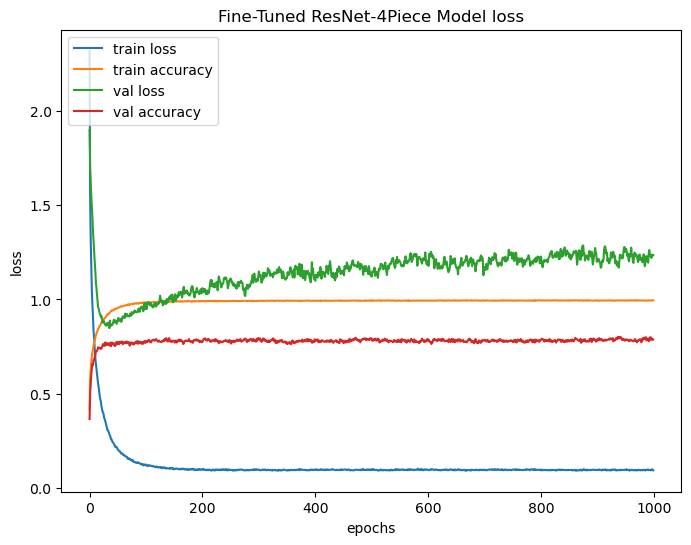

In [26]:
plot_train_loss(history, 'Fine-Tuned ResNet-4Piece Model')

### Model Evaluation

#### On Train Data

Now, after the model is being trained, we will look at the performance of the model on the training set.

In [27]:
train_preds = model1.predict(fine_tune_data_train)

 69/475 [===>..........................] - ETA: 0s

2022-10-09 17:04:14.605912: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


475/475 [==============================] - 1s 3ms/step


In [28]:
train_pred_labels = np.argmax(train_preds, axis=-1)

In [29]:
train_pred_labels

array([ 1, 13, 13, ...,  3,  9,  9])

In [30]:
np.sum(train_pred_labels == train_labels['label'])

15197

Looking at the misclassified images to get a better idea about what features the model is unable to capture.

In [31]:
mis_train_data = train_labels[train_pred_labels != train_labels['label']]
mis_train_data

,id,images,label
3597,3781,./Data/train/train/3781.tif,0
12255,12896,./Data/train/train/12896.tif,9
14569,15333,./Data/train/train/15333.tif,7


In [32]:
precision, recall, fscore, support = score(train_labels['label'], train_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,1.000000,0.998978,0.999488,978
1,1.000000,1.000000,1.000000,925
2,1.000000,1.000000,1.000000,925
3,1.000000,1.000000,1.000000,947
4,0.998926,1.000000,0.999463,930
5,1.000000,1.000000,1.000000,962
6,1.000000,1.000000,1.000000,998
7,1.000000,0.998905,0.999452,913
8,1.000000,1.000000,1.000000,1005
9,1.000000,0.998951,0.999475,953


#### On Train-Test Data

In [33]:
test_preds = model1.predict(fine_tune_data_test)

25/25 [==============================] - 0s 2ms/step


In [34]:
test_pred_labels = np.argmax(test_preds, axis=-1)

In [35]:
test_pred_labels

array([11,  8,  0,  1, 10,  6, 13,  8, 14,  1,  6, 15,  7, 14,  1, 11,  0,
        9,  6, 12,  8, 14,  3, 12,  6,  0,  3,  5,  3,  3, 11,  1,  6,  2,
        1,  8,  4,  5,  1,  9,  6, 12, 14,  2,  5, 14,  3,  0, 13,  4,  0,
       10, 12, 15,  1, 14, 10,  6,  9,  2, 15, 13,  2, 11, 13, 10,  8,  0,
        6,  3,  4,  4, 12, 15,  8,  6,  7,  0, 12, 11, 11,  9, 12, 12,  9,
        8, 13, 13, 13, 13, 10, 11,  4, 10,  7, 10, 11,  8, 13, 10,  3, 10,
       12,  9,  7, 14,  8,  2,  1, 15,  7,  5,  9,  4, 12, 12, 12,  1, 11,
        6, 13,  1,  0, 12, 13, 10, 10, 12,  0,  7,  3, 11,  6,  1,  6,  9,
       14, 10,  7, 14, 10,  8,  9, 12,  8,  5,  8,  9,  2, 13, 15, 14,  4,
       14,  4,  9,  4, 14,  7,  7,  8,  4,  4, 10, 13,  8, 15,  3,  8,  8,
       13,  6,  3, 11,  7, 12, 10, 14, 14,  8,  6, 10, 13, 11,  6, 13,  4,
       14, 11,  7, 15,  0,  3,  0, 10, 13, 12, 10, 11, 11, 15,  1,  9,  1,
        9,  5, 13, 14, 12,  1,  4,  8, 11,  6, 13,  5,  4, 12,  8,  0,  9,
       13, 15,  1,  7,  1

In [36]:
np.sum(test_pred_labels == test_labels['label'])

633

In [37]:
mis_train_data = test_labels[test_pred_labels != test_labels['label']]
mis_train_data

,id,images,label
2,33,./Data/train/train/33.tif,6
4,65,./Data/train/train/65.tif,14
5,67,./Data/train/train/67.tif,9
7,100,./Data/train/train/100.tif,10
19,372,./Data/train/train/372.tif,13
...,...,...,...
776,15528,./Data/train/train/15528.tif,5
779,15568,./Data/train/train/15568.tif,9
785,15621,./Data/train/train/15621.tif,15
788,15687,./Data/train/train/15687.tif,12


In [38]:
precision, recall, fscore, support = score(test_labels['label'], test_pred_labels)
pd.DataFrame({
    'precision': precision,
    'recall': recall,
    'fscore': fscore,
    'support': support
})

,precision,recall,fscore,support
0,0.750000,0.777778,0.763636,54
1,0.627451,0.727273,0.673684,44
2,0.902439,0.860465,0.880952,43
3,0.875000,0.913043,0.893617,46
4,0.853659,0.972222,0.909091,36
5,0.736842,0.560000,0.636364,50
6,0.847826,0.847826,0.847826,46
7,0.823529,0.807692,0.815534,52
8,0.870968,1.000000,0.931034,54
9,0.808511,0.808511,0.808511,47


In [39]:
np.mean(fscore)

0.7913431406712692

#### On Validation Data

Generating Predictions for the Validation Set

In [40]:
validation_data = pd.DataFrame({'images':['./Data/validation/validation/'+name for name in os.listdir('./Data/validation/validation/')]})
validation_data['id'] = [name.split('.')[0] for name in os.listdir('./Data/validation/validation/')]
validation_data['label'] = -1 # Simply added to prevent re-writing code
validation_data.sort_values(by=['id'], inplace=True)
validation_data

,images,id,label
850,./Data/validation/validation/17801.tif,17801,-1
898,./Data/validation/validation/17802.tif,17802,-1
852,./Data/validation/validation/17803.tif,17803,-1
798,./Data/validation/validation/17804.tif,17804,-1
750,./Data/validation/validation/17805.tif,17805,-1
...,...,...,...
246,./Data/validation/validation/18696.tif,18696,-1
211,./Data/validation/validation/18697.tif,18697,-1
760,./Data/validation/validation/18698.tif,18698,-1
787,./Data/validation/validation/18699.tif,18699,-1


In [41]:
fine_tune_data_validation = np.load('./Data/ResNet-4P-validation-precompute/whole_validation_data_precomp.npy')
fine_tune_data_validation.shape

(900, 5, 2048)

In [42]:
valid_preds = model1.predict(fine_tune_data_validation)

29/29 [==============================] - 0s 3ms/step


2022-10-09 17:04:16.225255: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [43]:
valid_pred_labels = np.argmax(valid_preds, axis=-1)

### Submission

For Kaggle Submission

In [44]:
submission_data = pd.DataFrame({'id':list(range(17801, 18701))})
submission_data['label'] = valid_pred_labels
submission_data

,id,label
0,17801,4
1,17802,6
2,17803,4
3,17804,8
4,17805,3
...,...,...
895,18696,7
896,18697,12
897,18698,8
898,18699,12


In [45]:
submission_data.to_csv('./Submissions/submission-resnet-4p.csv', index=False)